<a href="https://colab.research.google.com/github/SVJLucas/self-supervised-watermarking/blob/main/code/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import torch
import cv2
from torch import nn
import numpy as np
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel


# The Oxford 102 Flowers Dataset: A Brief Overview

The Oxford 102 Flowers dataset is a popular image classification dataset that contains 102 flower categories, each with 40-258 images. The images have large scale, pose, and light variations, making it a challenging dataset for image classification algorithms.

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!tar -xzf 102flowers.tgz

--2024-02-19 02:55:31--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz [following]
--2024-02-19 02:55:31--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2024-02-19 02:55:32--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting respo

## - What we will do:

We will conduct an experiment using 10 randomly selected images from the Oxford 102 dataset. Our goal is to explore the potential of self-supervised models in zero-watermarking and we're going to use this dataset for it.

In [3]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def download_random_flowers(num_images: int = 10, seed: int = 2024):
    """
    Selects and displays a specified number of random images from the Oxford 102 Flowers dataset.

    Args:
        num_images: The number of random images to display.
        seed: Seed for the random number generator to ensure reproducibility.

    Returns:
        None. Displays the selected images.
    """
    # Set the seed for reproducibility
    random.seed(seed)

    # Path to the directory where the images are extracted
    img_dir = 'jpg'

    # Initialize the data list
    data = []

    # Get all image filenames in the directory
    all_images = os.listdir(img_dir)

    # Select random images
    selected_images = random.sample(all_images, num_images)
    for i, img_name in enumerate(selected_images, start=1):
        img_path = os.path.join(img_dir, img_name)
        img = Image.open(img_path)
        img = np.array(img)
        data.append(img)

    return data

In [4]:
selected_images = 10
data = download_random_flowers()

Lets visualize the images:

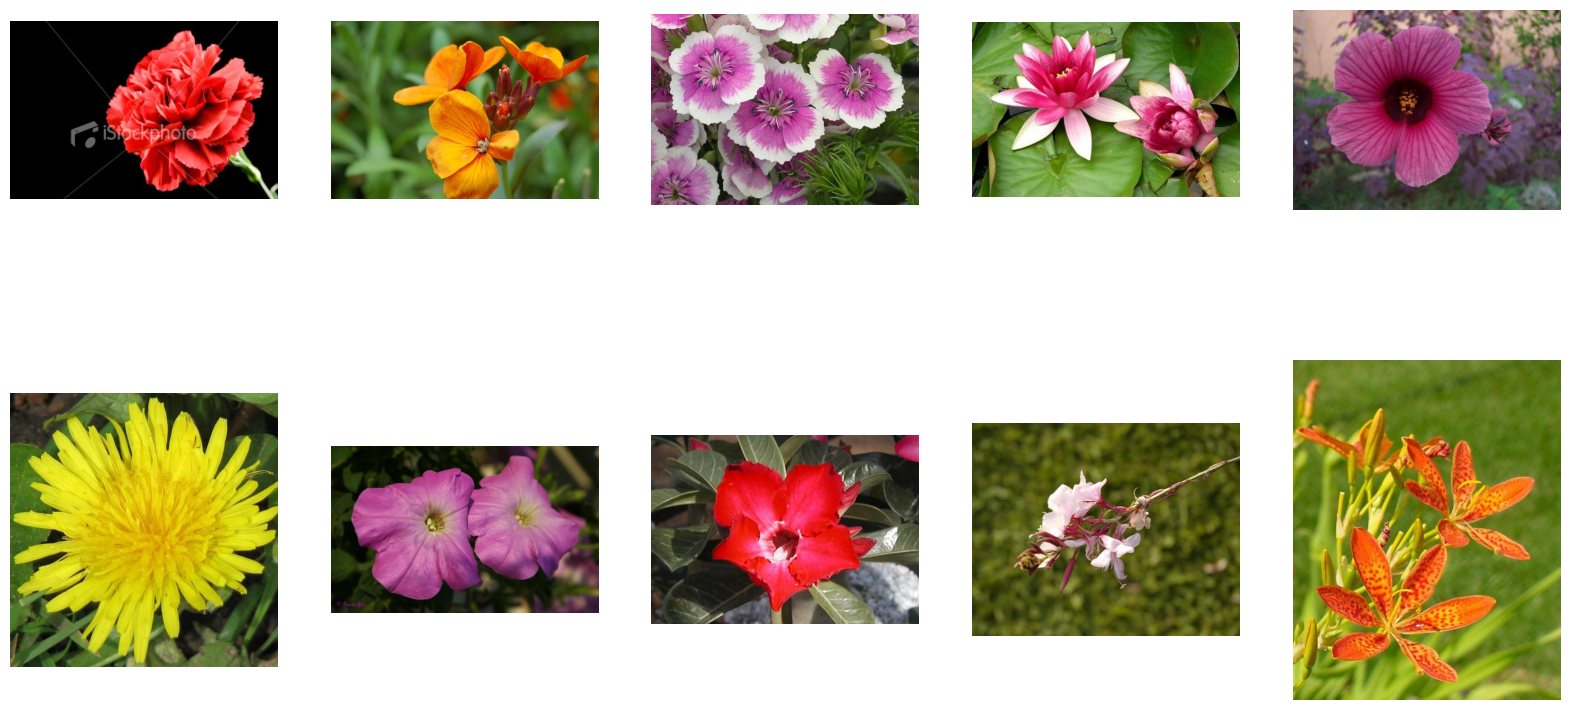

In [5]:
# Display the selected images
plt.figure(figsize=(20, 10))
for i, img in enumerate(data, start=1):
  plt.subplot(2, 5, i)
  plt.imshow(img)
  plt.axis('off')
plt.show()

# CLIP

CLIP (Contrastive Language-Image Pre-training) is a powerful deep learning model trained on massive amounts of text and image pairs. It learns connections between textual descriptions and their corresponding images, allowing it to perform various tasks. Here, we are going to use only the image embedding part of it to extract features from images.

In [6]:
class CLIP:
    """
    Embeds images using a pre-trained CLIP model.

    This class uses a pre-trained CLIP model to create embeddings for images.
    It performs text-image alignment, converts the image embeddings to
    binary representations using a sigmoid activation and thresholding,
    and returns them as numpy arrays.

    Args:
        None

    Attributes:
        model: CLIPModel instance from 'openai/clip-vit-base-patch32'.
        processor: CLIPProcessor instance from 'openai/clip-vit-base-patch32'.
        sigmoid: nn.Sigmoid activation function.
    """

    def __init__(self):
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.sigmoid = nn.Sigmoid()

    def embedding(self, image_batch):
        """Embeds a batch of images.

        This method takes a batch of images (as tensors) as input,
        processes them using the CLIP model, and returns their binary
        embeddings as numpy arrays.

        Args:
            image_batch: A PyTorch tensor of shape (batch_size, 3, height, width)
                representing the images to embed.

        Returns:
            A NumPy array of shape (batch_size, embedding_size) containing
            the binary embeddings of the images.
        """

        inputs = self.processor(text=[""] * len(image_batch), images=image_batch, return_tensors="pt", padding=True)
        outputs = self.model(**inputs)
        image_embeds = outputs.image_embeds

        # Apply sigmoid activation and thresholding
        binary_embeds = self.sigmoid(image_embeds)
        binary_embeds = torch.where(binary_embeds > 0.5, 1, 0)

        return binary_embeds.detach().cpu().numpy()

In [7]:
model = CLIP()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [15]:
embeddings = model.embedding(data)

In [16]:
embeddings

array([[0, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 1, 1, ..., 1, 1, 0]])

# Generating Watermark

Lets define a random watermark:

In [8]:
def get_watermark(size: int, seed: int = 42) -> np.ndarray:
    """
    Generates a binary watermark of a given size.

    This function creates a NumPy array of `size` elements, filled with randomly generated
    binary values (0 or 1). It uses the provided `seed` for reproducibility.

    Args:
        size (int): The size of the watermark (number of elements).
        seed (int, optional): The seed for the random number generator. Defaults to 42.

    Returns:
        np.ndarray: A NumPy array of shape (size,) containing the binary watermark.
    """

    np.random.seed(seed)  # Seed the random number generator for reproducibility
    watermark = np.random.randint(0, 2, size)  # Generate random binary values (0 or 1)
    return watermark

In [17]:
watermark =  get_watermark(embeddings.shape[1])

In [18]:
watermark

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,

# Extracting the Master Share of each image

In [9]:
def xor_with_matrix(A: np.ndarray, M: np.ndarray) -> np.ndarray:
    """
    Performs an XOR operation between a binary array A and each binary array in a matrix M.

    Args:
        A: A binary numpy array of shape (n,).
        M: A binary numpy matrix of shape (m, n), where each row is an array to XOR with A.

    Returns:
        A numpy matrix C of shape (m, n), where each element C[i][j] is the XOR of A[j] and M[i][j].
    """
    # Ensure A is a 2D row vector to facilitate broadcasting
    A_row_vector = A.reshape(1, -1)

    # Perform XOR operation
    return np.bitwise_xor(A_row_vector, M)

In [23]:
master_share = xor_with_matrix(watermark,embeddings)

In [24]:
master_share

array([[0, 1, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 1, 1]])

# Verifing watermark extraction with no attack

In [25]:
def xor_between_matrices(M1: np.ndarray, M2: np.ndarray) -> np.ndarray:
    """
    Performs a row-wise XOR operation between two matrices of the same shape.

    Args:
        M1: A binary numpy matrix of shape (m, n).
        M2: Another binary numpy matrix of shape (m, n), same as M1.

    Returns:
        A numpy matrix C of shape (m, n), where each element C[i][j] is the XOR of M1[i][j] and M2[i][j].
    """
    # Perform XOR operation row-wise
    return np.bitwise_xor(M1, M2)

In [26]:
extracted_watermark = xor_between_matrices(master_share,embeddings)

In [27]:
def calculate_nc_ber(extracted_watermark: np.ndarray, watermark: np.ndarray) -> tuple:
    """
    Calculates the Normalized Correlation (NC) and Bit Error Rate (BER) for each row
    in the extracted_watermark and watermark matrices, then averages the values.

    Args:
        extracted_watermark (np.ndarray): A numpy matrix where each row is an extracted watermark.
        watermark (np.ndarray): A numpy matrix where each row is the original watermark.

    Returns:
        A tuple containing the average NC and average BER for all rows.
    """
    # Initialize sums for NC and BER
    nc_sum = 0
    ber_sum = 0

    # Iterate over each row to calculate NC and BER
    for i in range(extracted_watermark.shape[0]):
        ew = extracted_watermark[i, :]
        wm = watermark

        # Calculate Normalized Correlation (NC)
        nc = np.sum(ew * wm) / np.sqrt(np.sum(ew**2) * np.sum(wm**2))
        nc_sum += nc

        # Calculate Bit Error Rate (BER)
        ber = np.sum(np.abs(ew - wm) / 2) / len(ew)
        ber_sum += ber

    # Calculate averages
    avg_nc = nc_sum / extracted_watermark.shape[0]
    avg_ber = ber_sum / extracted_watermark.shape[0]

    return avg_nc, avg_ber

In [28]:
avg_nc, avg_ber = calculate_nc_ber(extracted_watermark, watermark)
print(f'Watermarking Evaluation - NC: {avg_nc:.3f}, BER: {avg_ber:.3f}')

Watermarking Evaluation - NC: 1.000, BER: 0.000


# Simulating Attacks:



- **Rotation Attack Test**:The Rotation Attack Test evaluates an algorithm's tolerance to orientation changes by rotating images by a random angle within a specified range (e.g., -5 to 5 degrees). This simulates real-world variations in camera angle or object orientation, challenging the algorithm's ability to recognize rotated objects without loss of accuracy.

- **Noise Test**: The Noise Test assesses an algorithm's robustness against visual noise by adding Gaussian noise with a random standard deviation to images. This mimics sensor noise or low-light conditions, testing the algorithm's capability to maintain performance despite the presence of random pixel value fluctuations.

- **Crop Ratio Test**: The Crop Ratio Test determines the impact of partial visibility on algorithm performance by cropping a random percentage of the image's border and resizing it back to the original dimensions. This simulates scenarios where objects are partially occluded or outside the camera's field of view.

- **Resize Scale Test**: The Resize Scale Test investigates the algorithm's resilience to scale variations by resizing images by a random scale factor and then resizing back to original dimensions. It mimics real-world conditions of objects appearing larger or smaller due to changes in distance to the camera.

- **Gaussian Blur Test**: The Gaussian Blur Test examines an algorithm's ability to handle images with reduced sharpness by applying Gaussian blur with a random intensity. This simulates motion blur or out-of-focus conditions, challenging the algorithm's capacity to recognize blurred objects.

- **Brightness Test**: The Brightness Test evaluates how changes in image brightness affect an algorithm's performance by adjusting the brightness with a random value within a specified range. This test simulates variations in lighting conditions, from underexposure to overexposure.

- **Contrast Test**: The Contrast Test assesses the effect of contrast adjustments on an algorithm's accuracy by modifying the contrast of images with a random factor. This simulates conditions with varying levels of contrast, testing the algorithm's ability to discern objects against backgrounds with minimal to significant contrast differences.

Each attack provides insight into specific aspects of algorithm robustness, highlighting vulnerabilities and areas for improvement in handling real-world image variations.

In [36]:
def apply_transformations(images: list[np.ndarray], num_attacked_samples_per_image_per_test: int, seed: int = 42) -> dict:
    """
    Applies a series of transformation tests to a list of images and returns the results as a dictionary.

    Args:
        images (np.ndarray): A list of images as numpy arrays.
        num_attacked_samples_per_image_per_test (int): The number of transformed images generated for each test per original image.
        seed (int): To ensure reproducibility

    Returns:
        A dictionary where each key is the name of a test and the value is a list of lists of transformed images.
    """
    # To ensure reproducibility
    np.random.seed(seed)

    # Define the tests to be applied and their parameters
    tests = [
        ("Rotation Attack Test", (-5, -5)),
        ("Noise Test", (0.5, 0.6)),
        ("Crop Ratio Test", (0.0, 0.1)),
        ("Resize Scale Test", (0.9, 1.1)),
        ("Gaussian Blur Test", (0.5, 1.0)),
        ("Brightness Test", (-10, 10)),
        ("Contrast Test", (0.9, 1.1)),
    ]

    # Initialize the dictionary to store the results of the tests
    results = {}

    # Iterate over each defined test
    for test_name, params in tests:
        # Initialize a list to store the transformed images for this test
        transformed_images_list = []

        # Apply the test to each image in the provided list
        for img in images:
            for _ in range(num_attacked_samples_per_image_per_test):
                # Generate a random parameter value within the specified range for the test
                param_value = np.random.uniform(params[0], params[1])

                if test_name == "Rotation Attack Test":
                    # Calculate the rotation matrix and apply rotation
                    M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), param_value, 1)
                    transformed_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
                elif test_name == "Noise Test":
                    # Add Gaussian noise to the image
                    mean = 0
                    sigma = param_value ** 0.5
                    gauss = np.random.normal(mean, sigma, img.shape)
                    transformed_img = cv2.add(img, gauss.astype('uint8'))
                elif test_name == "Crop Ratio Test":
                    # Calculate crop percentage and apply cropping
                    cropped_img = img[int(img.shape[0]*param_value):int(img.shape[0]*(1-param_value)), int(img.shape[1]*param_value):int(img.shape[1]*(1-param_value))]
                elif test_name == "Resize Scale Test":
                    # Resize the image based on the scale factor
                    resized_img = cv2.resize(img, None, fx=param_value, fy=param_value, interpolation=cv2.INTER_LINEAR)
                elif test_name == "Gaussian Blur Test":
                    # Apply Gaussian blur
                    transformed_img = cv2.GaussianBlur(img, (0, 0), param_value)
                elif test_name == "Brightness Test":
                    # Adjust brightness
                    transformed_img = cv2.convertScaleAbs(img, alpha=1, beta=param_value)
                elif test_name == "Contrast Test":
                    # Adjust contrast
                    transformed_img = cv2.convertScaleAbs(img, alpha=param_value, beta=0)

                # Add the transformed image to the list for this test
                transformed_images_list.append(transformed_img)

        # Add the list of transformed images to the results dictionary
        results[test_name] = [transformed_images_list]

    return results

In [37]:
def calculate_psnr(original: np.ndarray, transformed: np.ndarray) -> float:
    """
    Calculates the Peak Signal-to-Noise Ratio between the original and the transformed image.

    Args:
        original (np.ndarray): The original image.
        transformed (np.ndarray): The transformed image.

    Returns:
        The PSNR value.
    """
    if original.shape!=transformed.shape:
      transformed = cv2.resize(transformed, (original.shape[1], original.shape[0]))
    mse = np.mean((original - transformed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def apply_transformations(images: list[np.ndarray], num_attacked_samples_per_image_per_test: int, seed: int = 42) -> dict:
    """
    Applies a series of transformation tests to a list of images and returns the results as a dictionary.
    Each entry includes the average PSNR and the list of transformed images for each test.

    Args:
        images (np.ndarray): A list of images as numpy arrays.
        num_attacked_samples_per_image_per_test (int): The number of transformed images generated for each test per original image.
        seed (int): To ensure reproducibility.

    Returns:
        A dictionary where each key is the name of a test and the value is a dictionary with 'PSNR' and 'Attacks'.
    """
    np.random.seed(seed)  # To ensure reproducibility

    tests = [
        ("Rotation Attack Test", (-5, -5)),
        ("Noise Test", (0.5, 0.6)),
        ("Crop Ratio Test", (0.0, 0.1)),
        ("Resize Scale Test", (0.9, 1.1)),
        ("Gaussian Blur Test", (0.3, 0.4)),
        ("Brightness Test", (-10, 10)),
        ("Contrast Test", (0.9, 1.1)),
    ]

    results = {}

    for test_name, params in tests:
        transformed_images_list = []
        psnr_values = []

        for img in images:
            transformed_images_list.append([])
            for _ in range(num_attacked_samples_per_image_per_test):
                param_value = np.random.uniform(params[0], params[1])
                transformed_img = apply_specific_transformation(test_name, img, param_value)
                transformed_images_list[-1].append(transformed_img)
                psnr_values.append(calculate_psnr(img, transformed_img))

        avg_psnr = np.mean(psnr_values)
        results[test_name] = {'PSNR': avg_psnr, 'Attacks': transformed_images_list}

    return results

def apply_specific_transformation(test_name: str, img: np.ndarray, param_value: float) -> np.ndarray:
    """
    Applies a specific transformation to an image based on the test name and parameter value.

    Args:
        test_name (str): The name of the transformation test.
        img (np.ndarray): The original image.
        param_value (float): The parameter value for the transformation.

    Returns:
        The transformed image.
    """
    if test_name == "Rotation Attack Test":
        M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), param_value, 1)
        return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    elif test_name == "Noise Test":
        gauss = np.random.normal(0, param_value ** 0.5, img.shape)
        return cv2.add(img, gauss.astype('uint8'))
    elif test_name == "Crop Ratio Test":
        crop_size = int(img.shape[0] * param_value), int(img.shape[1] * param_value)
        cropped_img = img[crop_size[0]:img.shape[0]-crop_size[0], crop_size[1]:img.shape[1]-crop_size[1]]
        return cv2.resize(cropped_img, (img.shape[1], img.shape[0]))
    elif test_name == "Resize Scale Test":
        resized = cv2.resize(img, None, fx=param_value, fy=param_value, interpolation=cv2.INTER_LINEAR)
        return cv2.resize(resized, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    elif test_name == "Gaussian Blur Test":
        return cv2.GaussianBlur(img, (0, 0), param_value)
    elif test_name == "Brightness Test":
        return cv2.convertScaleAbs(img, alpha=1, beta=param_value)
    elif test_name == "Contrast Test":
        return cv2.convertScaleAbs(img, alpha=param_value, beta=0)
    else:
        return img

In [40]:
num_attacked_samples_per_image_per_test = 100
transformed_data = apply_transformations(data, num_attacked_samples_per_image_per_test)

In [41]:
# Initialize a list to store the evaluation results of different tests.
evaluation_results = []

# Iterate over each test in the transformed data dictionary.
for test in transformed_data.keys():
    # Retrieve the PSNR value for the current test.
    psnr = transformed_data[test]['PSNR']

    # Initialize lists to store NC and BER values for the current test.
    nc = []
    ber = []

    # Iterate over the selected number of images to perform watermark embedding and extraction.
    for i in range(selected_images):
        # Embed the watermark into the ith transformed image using the model's embedding function.
        emb = model.embedding(np.array(transformed_data[test]['Attacks'][i]))

        # Extract the watermark from the embedded image by performing XOR with the master share.
        extracted_watermark = xor_with_matrix(master_share[i], emb)

        # Calculate the NC and BER between the extracted watermark and the original watermark.
        avg_nc, avg_ber = calculate_nc_ber(extracted_watermark, watermark)

        # Append the calculated NC and BER values to their respective lists.
        nc.append(avg_nc)
        ber.append(avg_ber)

    # Calculate the average NC and BER values for the current test across all selected images.
    nc = np.mean(nc)
    ber = np.mean(ber)

    # Append the evaluation results for the current test to the results list.
    evaluation_results.append({
        'Test': test,     # Name of the test
        'PSNR': psnr,     # Average PSNR value
        'NC': nc,         # Average NC value
        'BER': ber        # Average BER value
    })

    # Print the latest evaluation results.
    print(evaluation_results[-1])

{'Test': 'Rotation Attack Test', 'PSNR': 29.152791512401162, 'NC': 0.8624197601774874, 'BER': 0.07001953125}
{'Test': 'Noise Test', 'PSNR': 38.85488060646441, 'NC': 0.787196126316051, 'BER': 0.107029296875}
{'Test': 'Crop Ratio Test', 'PSNR': 31.141456093896057, 'NC': 0.9069945708402652, 'BER': 0.0471943359375}
{'Test': 'Resize Scale Test', 'PSNR': 37.40534270744649, 'NC': 0.9408077942646779, 'BER': 0.030125000000000002}
{'Test': 'Gaussian Blur Test', 'PSNR': 66.24464703526293, 'NC': 0.9953468015078062, 'BER': 0.0023720703125000003}
{'Test': 'Brightness Test', 'PSNR': 38.25468451836043, 'NC': 0.9756094568343195, 'BER': 0.01241796875}
{'Test': 'Contrast Test', 'PSNR': 36.54600561804045, 'NC': 0.9741270315614186, 'BER': 0.0131904296875}


In [42]:
evaluation_results = pd.DataFrame(evaluation_results)

CLIP results:

In [43]:
evaluation_results

,Test,PSNR,NC,BER
0,Rotation Attack Test,29.152792,0.862420,0.070020
1,Noise Test,38.854881,0.787196,0.107029
2,Crop Ratio Test,31.141456,0.906995,0.047194
3,Resize Scale Test,37.405343,0.940808,0.030125
4,Gaussian Blur Test,66.244647,0.995347,0.002372
5,Brightness Test,38.254685,0.975609,0.012418
6,Contrast Test,36.546006,0.974127,0.013190
